## dataset

In [1]:
from src.dataset import RecognitionDataset

dataset = RecognitionDataset(
    path='data/contest-data',
    split='train',
    alphabet='0123456789ABEKMHOPCTYX',
)

print(len(dataset))
dataset[2]

14028


{'image': Image([[[0.1882, 0.2196, 0.2078,  ..., 0.2118, 0.2118, 0.1765],
         [0.2000, 0.2275, 0.2157,  ..., 0.2510, 0.2510, 0.2118],
         [0.2078, 0.2431, 0.2353,  ..., 0.2784, 0.2824, 0.2392],
         ...,
         [0.1569, 0.1882, 0.1882,  ..., 0.1725, 0.1725, 0.1490],
         [0.1529, 0.1843, 0.1843,  ..., 0.1725, 0.1725, 0.1451],
         [0.1451, 0.1725, 0.1725,  ..., 0.1569, 0.1608, 0.1333]],
 
        [[0.1569, 0.1765, 0.1686,  ..., 0.1804, 0.1765, 0.1490],
         [0.1647, 0.1843, 0.1725,  ..., 0.2157, 0.2157, 0.1804],
         [0.1725, 0.2000, 0.1922,  ..., 0.2431, 0.2471, 0.2078],
         ...,
         [0.1216, 0.1451, 0.1451,  ..., 0.1255, 0.1255, 0.1098],
         [0.1176, 0.1412, 0.1412,  ..., 0.1255, 0.1255, 0.1059],
         [0.1098, 0.1333, 0.1333,  ..., 0.1137, 0.1176, 0.0980]],
 
        [[0.1686, 0.1922, 0.1804,  ..., 0.2000, 0.1961, 0.1608],
         [0.1765, 0.2000, 0.1882,  ..., 0.2353, 0.2353, 0.1961],
         [0.1843, 0.2157, 0.2078,  ..., 0.2627,

In [2]:
import torch
summed = torch.zeros_like(dataset[0]['image'])
for i in range(1,len(dataset)):
    summed += dataset[i]['image']

In [6]:
mean = summed.mean(dim=[1,2]) / len(dataset)
mean

tensor([0.4275, 0.4328, 0.4493])

In [8]:
error = torch.zeros_like(dataset[0]['image'])
for i in range(len(dataset)):
    error += (dataset[i]['image'] - mean[:, None, None]) ** 2

In [9]:
error.mean(dim=[1,2]) / len(dataset)

tensor([0.0613, 0.0621, 0.0626])

## validate data

In [1]:
import os

images = sorted(os.listdir('data/contest-data/train'))

In [13]:
from string import ascii_uppercase, digits


def compute_mask(text):
    """Compute letter-digit mask of text, e.g. 'E506EC152' -> 'LDDDLLDDD'.
    
    Args:
        - text: String of text. 
        
    Returns:
        String of the same length but with every letter replaced by 'L' and every digit replaced by 'D' 
        or None if non-letter and non-digit character met in text.
    """
    mask = []
    
    for char in text:
        if char in digits:
            mask.append("0")
        elif char in ascii_uppercase:
            mask.append("a")
        else:
            return None
    
    return "".join(mask)

In [14]:
images[40][10:-4]

'A368CM750'

In [15]:
masks = []
for img_file in images:
    name = img_file[10:-4]
    masks.append(compute_mask(name))

In [16]:
set(masks)

{'a000aa00', 'a000aa000'}

## make splits

In [2]:
import os

images = sorted(os.listdir('data/contest-data/labeled'))

In [3]:
import random

random.seed(0)
random.shuffle(images)

In [4]:
test_size = len(os.listdir('data/contest-data/test'))

val_images = images[:test_size]
train_images = images[test_size:]

In [5]:
import json

json.dump(val_images, open('data/contest-data/val.json', 'w'))
json.dump(train_images, open('data/contest-data/train.json', 'w'))
json.dump(images, open('data/contest-data/full-train.json', 'w'))

## visualize predictions

In [1]:
import torch

preds = torch.load('data/contest-data/predictions/19:38:15_10-12-2023/logits.pt', map_location='cpu')
preds.shape

torch.Size([20, 10518, 23])

In [2]:
alphabet = '0123456789ABEKMHOPCTYX'

In [3]:
from src.dataset import RecognitionDataset
from PIL import Image
import os


dataset = RecognitionDataset(
    path='data/contest-data',
    split='test',
    alphabet=alphabet,
)

dir_path = 'data/contest-data/test'
images = [Image.open(os.path.join(dir_path, p)) for p in dataset.image_files]

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from ctc_decoder import beam_search
from torch.nn.functional import softmax
import numpy as np


def show_probs(i):
    probs = softmax(preds[:, i, :], dim=1)
    txt = beam_search(probs.numpy(), chars=alphabet, beam_width=5)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 3.5))
    
    ax[0].imshow(images[i])
    ax[0].axis('off')
    ax[0].set_title(f'pred: {txt}')
    sns.heatmap(probs.T, ax=ax[1])
    ax[1].set_ylabel('char')
    ax[1].set_yticks(ticks=np.arange(23)+.5, labels=list(alphabet)+['-'], rotation=0, va='center')
    ax[1].set_xlabel('time step')
    ax[1].xaxis.tick_top() 
    ax[1].xaxis.set_label_position('top') 
    plt.show()


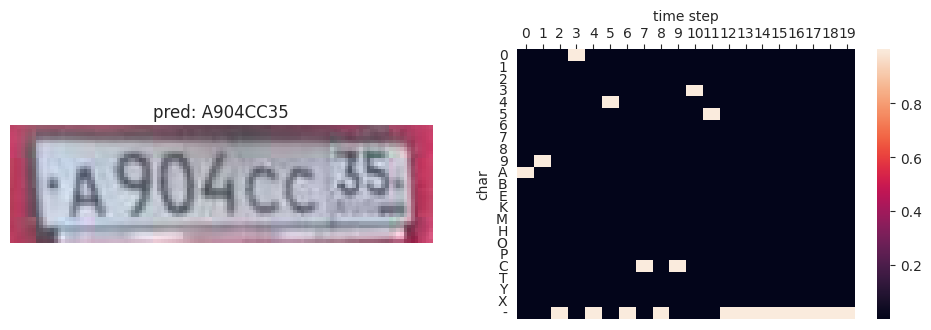

In [12]:
show_probs(0)

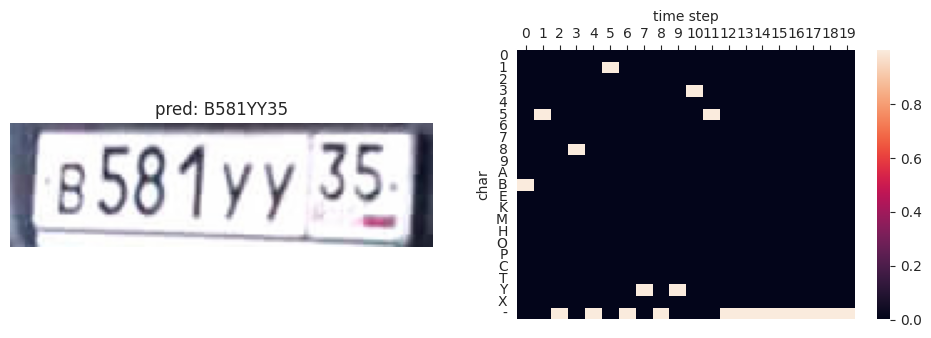

In [13]:
show_probs(1)

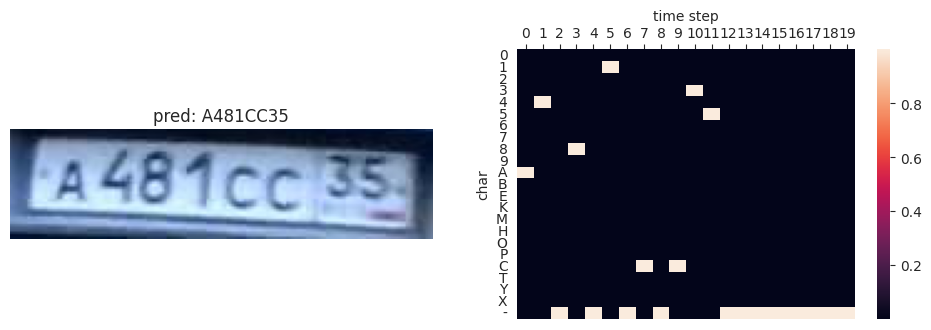

In [14]:
show_probs(2)

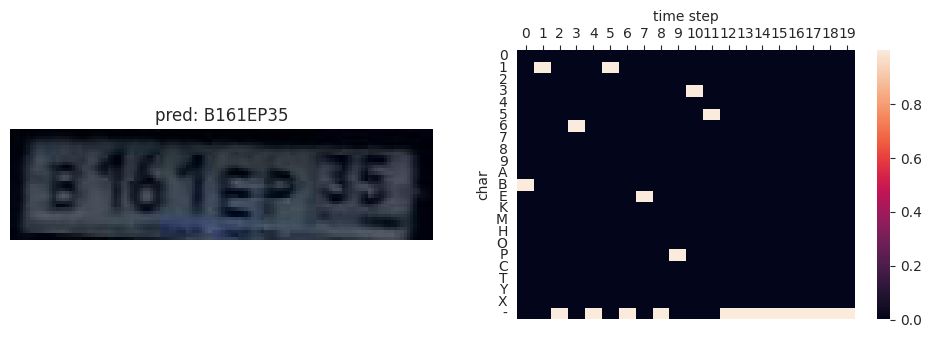

In [15]:
show_probs(3)

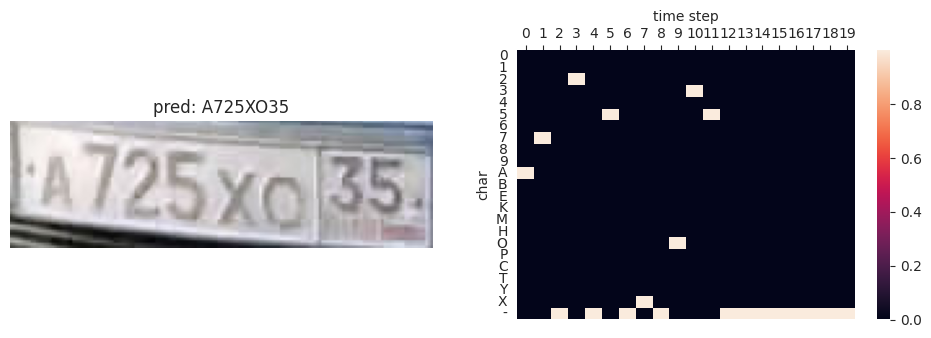

In [16]:
show_probs(4)

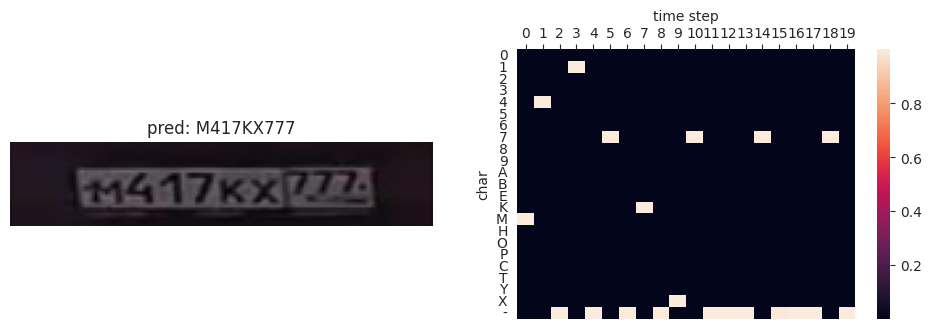

In [17]:
show_probs(5)

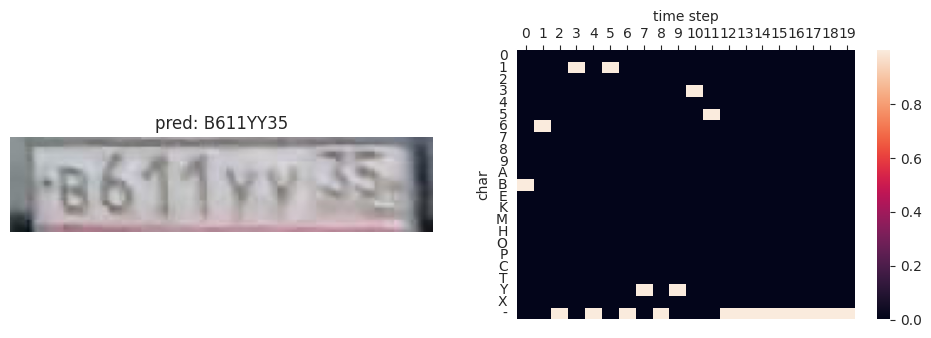

In [18]:
show_probs(6)

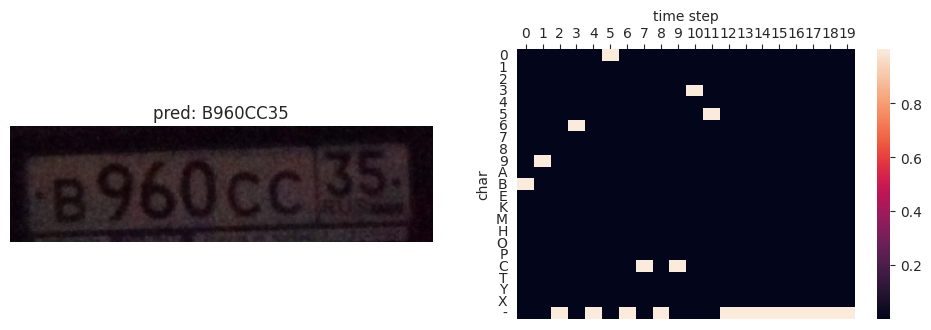

In [19]:
show_probs(7)

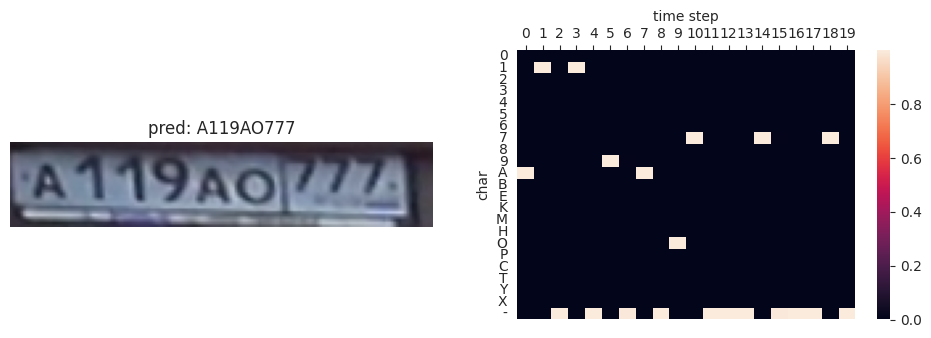

In [20]:
show_probs(8)

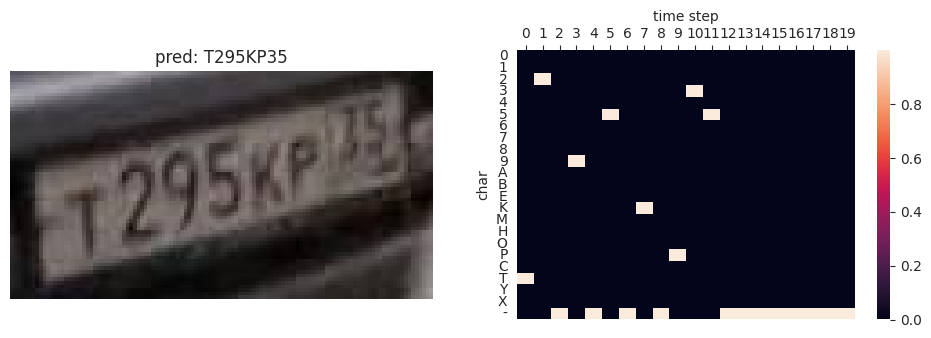

In [21]:
show_probs(9)

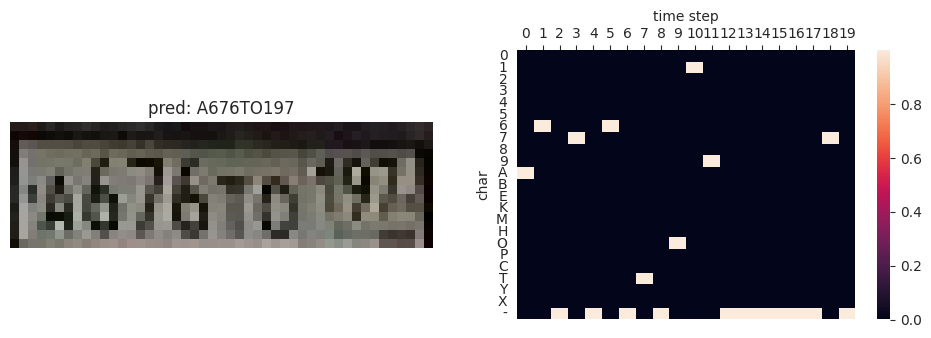

In [22]:
show_probs(10)

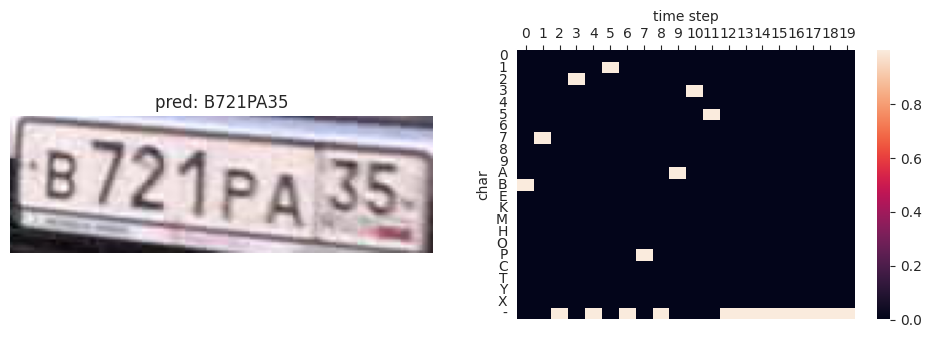

In [23]:
show_probs(11)

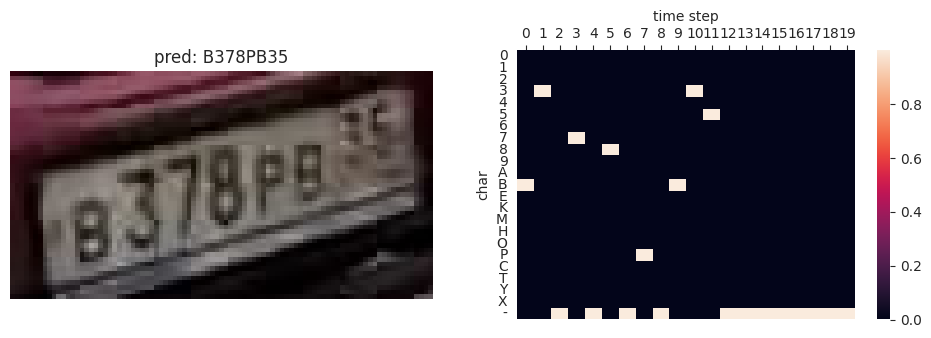

In [24]:
show_probs(12)

In [5]:
def save_photo(i):
    probs = softmax(preds[:, i, :], dim=1)
    txt = beam_search(probs.numpy(), chars=alphabet, beam_width=5)

    fig, ax = plt.subplots(1, 2, figsize=(12, 3.5))

    ax[0].imshow(images[i])
    ax[0].axis('off')
    ax[0].set_title(f'pred: {txt}')
    sns.heatmap(probs.T, ax=ax[1])
    ax[1].set_ylabel('char')
    ax[1].set_yticks(ticks=np.arange(23)+.5, labels=list(alphabet)+['-'], rotation=0, va='center')
    ax[1].set_xlabel('time step')
    ax[1].xaxis.tick_top() 
    ax[1].xaxis.set_label_position('top') 

    plt.savefig(f'data/contest-data/predictions/photos/{i}.jpg', bbox_inches='tight')
    plt.clf()

In [7]:
os.listdir('data/contest-data/predictions/photos/')[-1]

'4013.jpg'

In [ ]:
for i in range(5123, preds.shape[1]):
    save_photo(i)

## incorrect predictions

In [1]:
import pandas as pd

df = pd.read_csv('data/contest-data/predictions/23:46:51_10-12-2023/submission.csv')
df.head()

,pred,true
0,C457PO750,C457PO750
1,B510AX35,B510AX35
2,O171EY197,O171EY197
3,B044HE35,B044HE35
4,T775YA197,T775YA197


In [3]:
errors = df[df['pred'] != df['true']]
shape = errors.shape
print(shape)
errors.head(shape[0])

(10, 2)


,pred,true
59,Y012EE35,Y012EE75
86,A428OT177,A428OT197
144,C191EA27,C191EA21
273,C562OP750,Y520KE150
310,K736XY199,K736KY199
463,M087ET190,M027ET190
841,E036PY170,E036PY178
921,B844OO35,B834OO35
973,A813XE190,A813XB190
977,B141PM77,B141PM777


In [4]:
df['true'].unique().shape

(936,)

In [7]:
paths = [
    'data/contest-data/labeled/rus_02229_Y012EE75.png',
    'data/contest-data/labeled/rus_04470_A428OT197.png',
    'data/contest-data/labeled/rus_06281_C191EA21.png',
    'data/contest-data/labeled/rus_08160_Y520KE150.png',
    'data/contest-data/labeled/rus_08737_K736KY199.png',
    'data/contest-data/labeled/rus_02036_M027ET190.png',
    'data/contest-data/labeled/rus_06293_E036PY178.png',
    'data/contest-data/labeled/rus_13353_B834OO35.png',
    'data/contest-data/labeled/rus_05162_A813XB190.png',
    'data/contest-data/labeled/rus_09526_B141PM777.png'
]

In [14]:
errors.iloc[0]['true']

'Y012EE75'

In [16]:
import matplotlib.pyplot as plt
from PIL import Image

def show(pred, true, path):
    img = Image.open(path)
    plt.imshow(img)
    plt.title(f'pred: {pred} / true: {true}')
    plt.axis('off')
    plt.show()

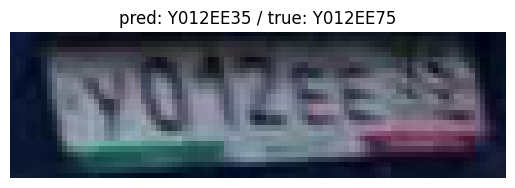

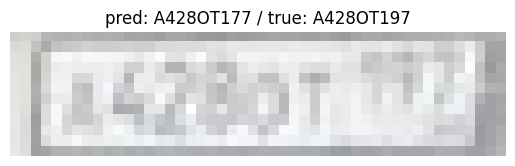

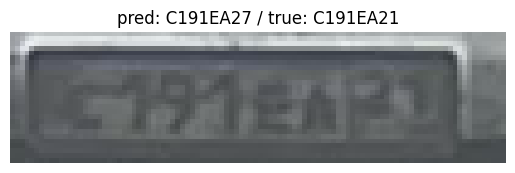

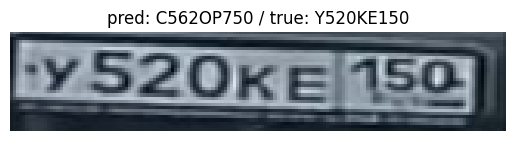

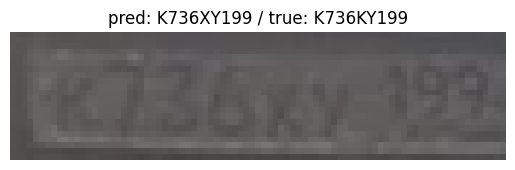

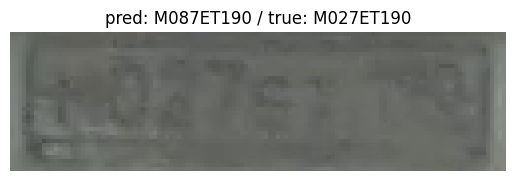

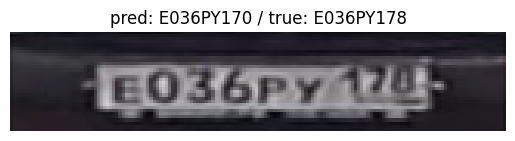

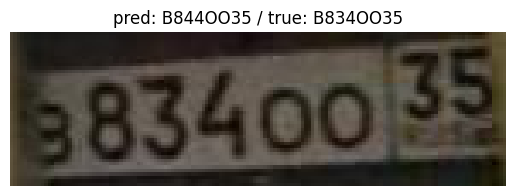

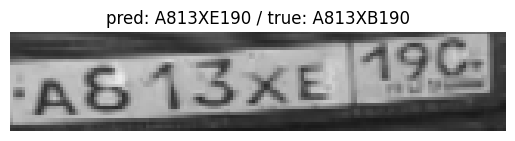

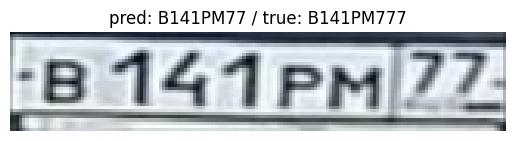

In [17]:
for i in range(10):
    show(errors.iloc[i]['pred'], errors.iloc[i]['true'], paths[i])